## Dimensionality Reduction and Unsupervised Clustering for EELS-SI
Jinseok Ryu (jinseuk56@gmail.com)<br>
Electron Microscopy and Spectroscopy Lab.<br>
Dept. of Materials Science and Engineering, Seoul National University<br>

This notebook demonstrates an example of the research work described in <u><strong>J. Ryu et al. (2021), Ultramicroscopy.</strong></u> (https://doi.org/10.1016/j.ultramic.2021.113314)<br>
To obtain the detailed information, please read the article.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from sklearn.cluster import OPTICS
import tkinter.filedialog as tkf
import tifffile
import ipywidgets as pyw
import time
plt.rcParams['font.family'] = 'Times New Roman'

In [2]:
# create a customized color group
color_rep = ["black", "red", "green", "blue", "orange", "purple", "yellow", "lime", 
             "cyan", "magenta", "lightgray", "peru", "springgreen", "deepskyblue", 
             "hotpink", "darkgray"]

custom_cmap = mcolors.ListedColormap(color_rep)
bounds = np.arange(-1, len(color_rep))
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=len(color_rep))
sm = cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])

cm_rep = ["gray", "Reds", "Greens", "Blues", "Oranges", "Purples"]

In [3]:
def zero_one_rescale(spectrum):
    """
    normalize one spectrum from 0.0 to 1.0
    """
    spectrum = spectrum.clip(min=0.0)
    min_val = np.min(spectrum)
    
    rescaled = spectrum - min_val
    
    if np.max(rescaled) != 0:
        rescaled = rescaled / np.max(rescaled)
    
    return rescaled

In [4]:
def reshape_coeff(coeffs, new_shape):
    """
    reshape a coefficient matrix to restore the original scanning shapes
    """
    coeff_reshape = []
    for i in range(len(new_shape)):
        temp = coeffs[:int(new_shape[i, 0]*new_shape[i, 1]), :]
        coeffs = np.delete(coeffs, range(int(new_shape[i, 0]*new_shape[i, 1])), axis=0)
        temp = np.reshape(temp, (new_shape[i, 0], new_shape[i, 1], -1))
        #print(temp.shape)
        coeff_reshape.append(temp)
        
    return coeff_reshape

In [5]:
def label_arrangement(label_arr, new_shape):
    """
    reshape a clustering result to restore the original scanning shapes
    """
    label_sort = np.unique(label_arr)
    num_label = len(label_sort)
    hist, edge = np.histogram(label_arr, bins=num_label)
    label_reshape = reshape_coeff(label_arr.reshape(-1, 1), new_shape)
        
    return label_reshape, hist

In [6]:
file_adr = tkf.askopenfilenames() # ".\data\example_EELS-SI_01.tif"

num_img = len(file_adr)
print("number of spectrum images: ", num_img)

number of spectrum images:  1


In [7]:
# load data
# example files -> 3D TIFF files
# If you want to load DM (.dm3 or .dm4) files directly, you can use the Hyperspy package

dataset_original = []
scan_shape = []
for adr in file_adr:
    tmp_img = tifffile.imread(adr)
    print(tmp_img.shape)
    dataset_original.append(tmp_img)
    scan_shape.append(tmp_img.shape)

scan_shape = np.asarray(scan_shape)
dataset = dataset_original

(80, 80, 1600)


In [8]:
# spectrum information (unit: eV)
offset = -2.0
n_channel = 1600
dispersion = 0.01 # [-2.0 eV, 14.0 eV), 1600 energy channels, 0.01 eV/channel
e_range = np.arange(offset, offset+n_channel*dispersion, 0.01)
print(len(e_range))

1600


In [9]:
# crop each spectrum (optional)
cr_offset = 0.5 # unit: eV
cr_channel = 300 # [0.5 eV, 3.5 eV), 300 energy channels, 0.01 eV/channel
ini_index = int((cr_offset - offset) / dispersion)
fin_index = ini_index + cr_channel
print(ini_index, fin_index)

dataset_cropped = []
for img in dataset:
    dataset_cropped.append(img[:, :, ini_index:fin_index])

n_channel = cr_channel
e_range = e_range[ini_index:fin_index]
dataset = dataset_cropped

250 550


In [10]:
# normalize each spectrum (optional)
dataset_normalized = []
for img in dataset:
    tmp = []
    for spectrum in img.reshape(-1, n_channel):
        tmp.append(zero_one_rescale(spectrum))
    dataset_normalized.append(np.asarray(tmp).reshape(img.shape))
    
dataset = dataset_normalized

In [11]:
# create a dataset (merge spectrum images into one data matrix)
print(num_img, n_channel)
dataset_input = []
for i in range(num_img):
    dataset_input.extend(dataset[i].reshape(-1, n_channel).tolist())
    
dataset_input = np.asarray(dataset_input)
print(dataset_input.shape)

1 300
(6400, 300)


In [12]:
# NMF decomposition
# please visit the below link for the detailed information on NMF
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html?highlight=nmf#sklearn.decomposition.NMF

nmf_num_comp = 5 # number of loading vectors
skl_nmf = NMF(n_components=nmf_num_comp, init="nndsvda", solver="mu", max_iter=2000, 
              verbose=True, beta_loss="frobenius", l1_ratio=0.0, alpha=0.0)

skl_coeffs = skl_nmf.fit_transform(dataset_input)
skl_comp_vectors = skl_nmf.components_
print(skl_coeffs.shape)
print(skl_comp_vectors.shape)

Epoch 10 reached after 0.041 seconds, error: 175.643499
Epoch 20 reached after 0.071 seconds, error: 173.074050
Epoch 30 reached after 0.101 seconds, error: 172.008749
Epoch 40 reached after 0.130 seconds, error: 171.230713
Epoch 50 reached after 0.159 seconds, error: 170.712951
Epoch 60 reached after 0.189 seconds, error: 170.365903
Epoch 70 reached after 0.217 seconds, error: 170.123577
Epoch 80 reached after 0.249 seconds, error: 169.951254
Epoch 90 reached after 0.282 seconds, error: 169.826757
Epoch 100 reached after 0.309 seconds, error: 169.733693
Epoch 110 reached after 0.336 seconds, error: 169.662295
Epoch 120 reached after 0.364 seconds, error: 169.606366
Epoch 130 reached after 0.394 seconds, error: 169.561086
Epoch 140 reached after 0.422 seconds, error: 169.523568
Epoch 150 reached after 0.449 seconds, error: 169.492015
(6400, 5)
(5, 300)


In [46]:
# convert the coefficient matrix into the coefficient maps
num_comp = nmf_num_comp
coeffs = skl_coeffs.copy()
coeffs_reshape = reshape_coeff(coeffs, scan_shape)

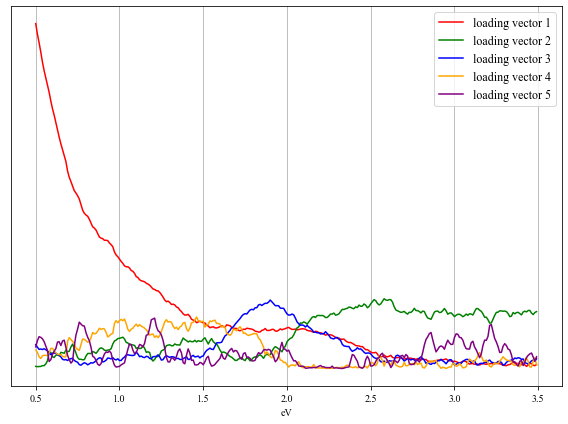

In [14]:
# visualize the loading vectors

fig, ax = plt.subplots(1, 1, figsize=(8, 6)) # all loading vectors
for i in range(nmf_num_comp):
    ax.plot(e_range, skl_comp_vectors[i], "-", c=color_rep[i+1], label="loading vector %d"%(i+1))
ax.grid()
ax.legend(fontsize="large")
ax.set_xlabel("eV", fontsize=10)
ax.tick_params(axis="x", labelsize=10)
ax.axes.get_yaxis().set_visible(False)

fig.tight_layout()
plt.show()

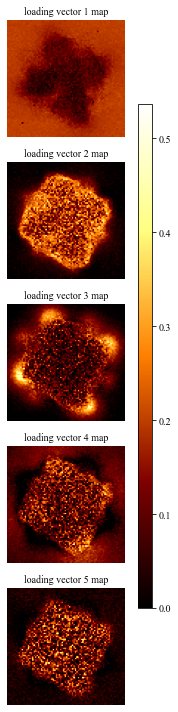

In [15]:
# visualize the coefficient maps

fig, ax = plt.subplots(num_comp, num_img, figsize=(5, 10))
min_val = np.min(coeffs)
max_val = np.max(coeffs)
if num_img != 1:
    for i in range(num_comp):
        for j in range(num_img):
            tmp = ax[i][j].imshow(coeffs_reshape[j][:, :, i], vmin=min_val, vmax=max_val, cmap="afmhot")
            ax[i][j].set_title("loading vector %d map"%(i+1), fontsize=10)
            ax[i][j].axis("off")
            
else:
    for i in range(num_comp):
        tmp = ax[i].imshow(coeffs_reshape[0][:, :, i], vmin=min_val, vmax=max_val, cmap="afmhot")
        ax[i].set_title("loading vector %d map"%(i+1), fontsize=10)
        ax[i].axis("off")

fig.tight_layout()
fig.colorbar(tmp, cax=fig.add_axes([0.70, 0.15, 0.04, 0.7]))
plt.show()

In [ ]:
# visualize the dimensionality-reduced space (NMF)
# You can select two of loading vectors using the interative widgets
%matplotlib qt
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

def projection(c1, c2):
    ax.cla()
    ax.scatter(coeffs[:, c1-1], coeffs[:, c2-1], s=30, c="black", alpha=0.5)
    ax.grid()
    ax.set_xlabel("loading vector %d"%(c1+1), fontsize=15)
    ax.set_ylabel("loading vector %d"%(c2+1), fontsize=15)
    ax.tick_params(axis="both", labelsize=15)
    fig.canvas.draw()
    fig.tight_layout()

st = {"description_width": "initial"}
l1_widget = pyw.IntText(value=1, description="1st loading vector", style=st)
l2_widget = pyw.IntText(value=2, description="2nd loading vector", style=st)

pyw.interact(projection, c1=l1_widget, c2=l2_widget)
plt.show()

In [47]:
# non-linear dimensionality reduction (t-SNE)
# apply t-SNE to the coefficient matrix produced by NMF decomposition
# please visit the below link for the detailed information on t-SNE
# https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html?highlight=tsne#sklearn.manifold.TSNE
start = time.time()
perplex = 35 # perplexity
num_comp_vis = 2 # number of dimensions of final data before clustering
tsne = TSNE(n_components=num_comp_vis, perplexity=perplex, early_exaggeration=5.0, learning_rate=300.0, 
                init="random", n_iter=1000, verbose=0)
tsne.fit_transform(coeffs)
print("%.2f min have passed"%((time.time()-start)/60))

0.30 min have passed


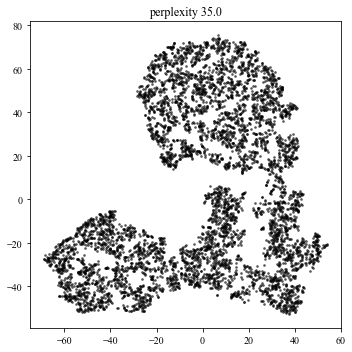

In [48]:
# select a proper dimensionality-reduced space for clustering
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(tsne.embedding_[:, 0], tsne.embedding_[:, 1], s=3, c="black", alpha=0.5)
ax.set_title("perplexity %.1f"%(perplex))
fig.tight_layout()
plt.show()

In [49]:
# build a data matrix for clustering after performing t-SNE
num_comp = num_comp_vis
coeffs = tsne.embedding_.copy()

comp_axes = np.arange(num_comp)

X = np.stack((coeffs[:, comp_axes[0]], coeffs[:, comp_axes[1]]), axis=1)
print(X.shape)

(6400, 2)


0.08 min have passed


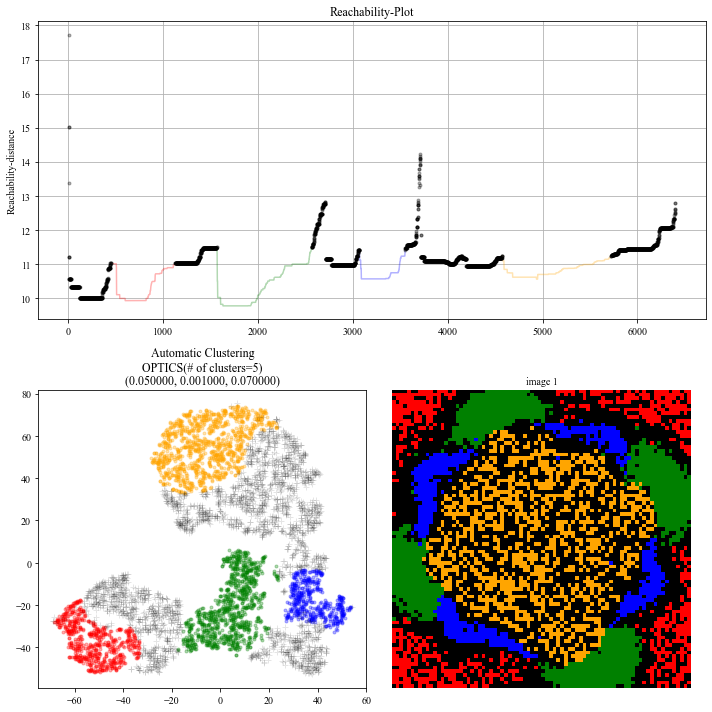

In [51]:
# unsupervised clustering (OPTICS)
# You can adjust the hyperparameters using the interative widgets
# please visit the below link for the detailed information on OPTICS
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html?highlight=optics#sklearn.cluster.OPTICS
start = time.time()

fig = plt.figure(figsize=(10, 10))
G = gridspec.GridSpec(2, 4)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, :2])
ax3 = plt.subplot(G[1, 2:])

label_result = {"label_0":[]}

msample, steep, msize = 0.05, 0.001, 0.07
clust = OPTICS(min_samples=msample, xi=steep, min_cluster_size=msize).fit(X)
space = np.arange(len(X))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]
labels_0 = clust.labels_

for klass, color in zip(range(0, len(color_rep)), color_rep[1:]):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)    
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.set_ylabel('Reachability-distance')
ax1.set_title('Reachability-Plot')
ax1.grid()
        
for klass, color in zip(range(0, len(color_rep)), color_rep[1:]):
    Xo = X[labels_0 == klass]
    ax2.scatter(Xo[:, 0], Xo[:, 1], color=color, alpha=0.3, marker='.')
ax2.plot(X[labels_0 == -1, 0], X[labels_0 == -1, 1], 'k+', alpha=0.1)
ax2.set_title('Automatic Clustering\nOPTICS(# of clusters=%d)\n(%f, %f, %f)'%(len(np.unique(labels_0)), msample, steep, msize))
        
label_reshape_0, _ = label_arrangement(labels_0, scan_shape)

img_sel = 1
ax3.imshow(label_reshape_0[img_sel-1], cmap=custom_cmap, norm=norm)
ax3.set_title("image %d"%(img_sel), fontsize=10)
ax3.axis("off")

fig.tight_layout()
    
print("%.2f min have passed"%((time.time()-start)/60))
plt.show()

In [52]:
# reshape the clustering result
label_selected = labels_0.copy()
label_sort = np.unique(label_selected)
label_reshape, hist = label_arrangement(label_selected, scan_shape)
num_label = len(label_sort)
print(label_sort) # label "-1" -> not a cluster
print(hist) # number of data points in each cluster

[-1  0  1  2  3]
[3085  679 1002  483 1151]


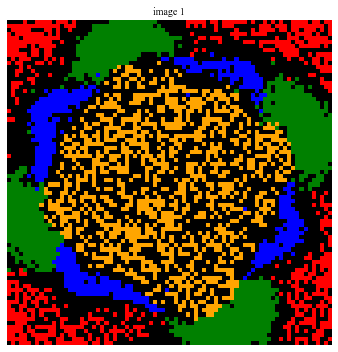

In [53]:
# clustering result - spatial distribution of each cluster
    
fig, ax = plt.subplots(1, num_img, figsize=(10, 5))
if num_img != 1:
    for i, axs in enumerate(ax.flat):
        axs.imshow(label_reshape[i], cmap=custom_cmap, norm=norm)
        axs.set_title("image %d"%(i+1), fontsize=10)
        axs.axis("off")

else:
    ax.imshow(label_reshape[0], cmap=custom_cmap, norm=norm)
    ax.set_title("image %d"%(1), fontsize=10)
    ax.axis("off")
#fig.colorbar(sm)
fig.tight_layout()

number of pixels in the label -1 cluster: 3085
number of pixels in the label 0 cluster: 679
number of pixels in the label 1 cluster: 1002
number of pixels in the label 2 cluster: 483
number of pixels in the label 3 cluster: 1151


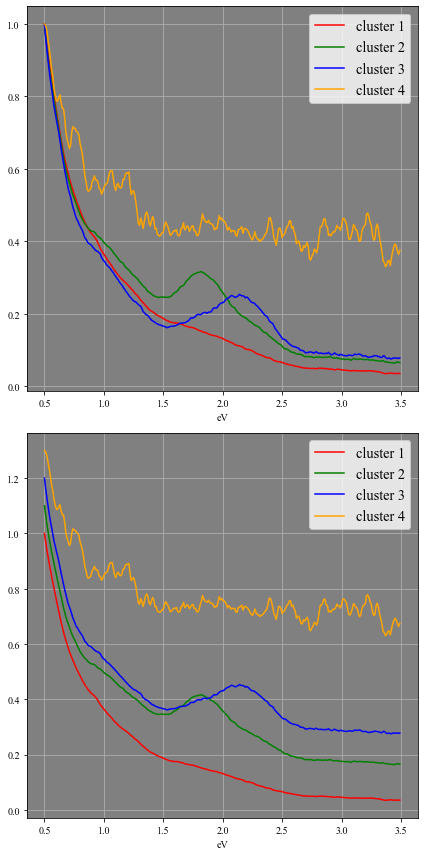

In [54]:
# clustering result - representative spectra
# average all of the spectra in each cluster
lines = np.zeros((num_label, n_channel))

for i in range(num_label):
    ind = np.where(label_selected == label_sort[i])
    print("number of pixels in the label %d cluster: %d"%(label_sort[i], hist[i]))
    lines[i] = np.mean(dataset_input[ind], axis=0)
    
fig, ax = plt.subplots(2, 1, figsize=(6, 12))

# normalize the representative spectra
lines = lines / np.max(lines, axis=1)[:, np.newaxis]

if -1 in label_sort: # to exclude the label -1 (unclassified data points)
    for i in range(1, num_label):
        ax[0].plot(e_range, (lines[i]), label="cluster %d"%(i), c=color_rep[i])
        ax[1].plot(e_range, (lines[i]+(i-1)*0.1), label="cluster %d"%(i), c=color_rep[i])
        
else:
    for i in range(0, num_label):
        ax[0].plot(e_range, (lines[i]), label="cluster %d"%(i+1), c=color_rep[i+1])
        ax[1].plot(e_range, (lines[i]+i*0.1), label="cluster %d"%(i+1), c=color_rep[i+1])

ax[0].grid()
ax[0].legend(fontsize="x-large")
ax[0].set_xlabel("eV")
ax[0].set_facecolor("gray")
ax[1].grid()
ax[1].legend(fontsize="x-large")
ax[1].set_xlabel("eV")
ax[1].set_facecolor("gray")
fig.tight_layout()
plt.show()